### Imports

In [5]:

import tensorflow as tf
print(tf.__version__)


2.18.0


In [6]:
# Standard Libraries
import os

# Data Handling
import numpy as np
import pandas as pd
from imblearn.over_sampling import ADASYN, SMOTE

# Machine Learning & Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
from sklearn.preprocessing import StandardScaler

# Hyperparameter Optimization
import optuna

# Model Saving & Experiment Tracking
import joblib
import mlflow
import mlflow.sklearn

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
print("mlflow ui --port 5000")


mlflow ui --port 5000


In [8]:
TRACKING_URI = "azureml://northeurope.api.azureml.ms/mlflow/v1.0/subscriptions/716d3e14-e009-4f92-89c9-01fa8347272a/resourceGroups/adda23ac-rg/providers/Microsoft.MachineLearningServices/workspaces/fall"
mlflow.set_tracking_uri(TRACKING_URI)

### Load data

In [9]:
def load_data(file_name):
    '''
    Load data from a csv file into a pandas dataframe.
    
    Args:
    file_name: The name of the csv file to load
    
    Returns:
    df: A pandas dataframe containing the data from the csv file
    '''
    folder = "datasets"

    df = pd.read_csv(f"{folder}/{file_name}")
    return df

### Stratify Split

In [10]:
def stratified_activity_split(df, target_column="fall_binary", test_size=0.2, random_state=42):
    """
    Splits the dataset while ensuring 20% of each 'activity' is in the test set.

    Args:
        df (pd.DataFrame): The full dataset containing 'activity' and the target variable.
        target_column (str): The column representing the target labels.
        test_size (float): The fraction of each activity to be in the test set.
        random_state (int): Random seed for reproducibility.

    Returns:
        data_train (pd.DataFrame): Training set.
        data_test (pd.DataFrame): Test set.
    """

    train_list = []
    test_list = []

    # ✅ Loop through each activity and apply train-test split
    for activity, group in df.groupby("activity"):
        train, test = train_test_split(group, test_size=test_size, random_state=random_state, stratify=group[target_column])
        train_list.append(train)
        test_list.append(test)

    # ✅ Concatenate results into train & test datasets
    data_train = pd.concat(train_list).reset_index(drop=True)
    data_test = pd.concat(test_list).reset_index(drop=True)

    return data_train, data_test


### Evaluate Per Activity / Distance Functions

In [11]:
def evaluate_per_activity(model, test_X, test_y, feature_columns=None):
    """
    Evaluates model performance per activity type and logs the results in MLflow.

    Args:
        model: The trained model (LSTM or Tree-based).
        test_X: Test feature data (DataFrame).
        test_y: Test target labels (Series).
        target_column: The name of the target column.
        feature_columns: The feature columns used for training.

    Returns:
        A DataFrame containing classification results per activity.
    """
    
    # ✅ Ensure X_test is a DataFrame
    if not isinstance(test_X, pd.DataFrame):
        test_X = pd.DataFrame(test_X, columns=feature_columns)

    # ✅ Ensure y_test is a Series
    if isinstance(test_y, pd.DataFrame):
        test_y = test_y.squeeze()  # Convert to Series if needed

    # ✅ Ensure 'activity' column exists
    if "activity" not in test_X.columns:
        raise ValueError("Dataset does not contain an 'activity' column.")

    is_lstm = isinstance(model, tf.keras.Model)
    results = []

    # ✅ Loop through each unique activity and evaluate model performance
    for activity in test_X["activity"].unique():
        # Filter test data for the current activity
        X_test_activity = test_X[test_X["activity"] == activity].copy()

        # Extract the actual labels
        y_test_activity = test_y.loc[X_test_activity.index].values.flatten()  # Ensure correct shape

        # ✅ Check for missing values
        if np.isnan(y_test_activity).any():
            print(f"Warning: NaN values found in y_test_activity for activity {activity}!")
            y_test_activity = np.nan_to_num(y_test_activity, nan=0)  # Replace NaN with 0 (No Fall)

        # ✅ Ensure y_test_activity is integer
        try:
            y_test_activity = y_test_activity.astype(int)
        except ValueError as e:
            print(f"Error converting y_test_activity to integer for activity {activity}: {e}")
            continue  # Skip this activity if conversion fails

        # ✅ Select feature columns
        if is_lstm:
            feature_columns = [col for col in X_test_activity.columns if col.startswith("value")]

        X_test_activity = X_test_activity[feature_columns].values  # Extract feature values

        print(f"Activity: {activity}, X shape: {X_test_activity.shape}, y shape: {y_test_activity.shape}")

        # ✅ Reshape X for LSTM input
        if is_lstm:
            X_test_activity = X_test_activity.reshape(-1, 500, 1)

        # ✅ Predict fall_binary values
        y_pred = model.predict(X_test_activity).round().astype(int).flatten()

        # ✅ Compute correct and incorrect counts
        correct = np.sum(y_pred == y_test_activity)
        incorrect = len(y_pred) - correct

        # ✅ Determine if the first sample of the activity is a fall or not
        actual_fall = "Fall" if y_test_activity[0] == 1 else "No Fall"

        print(f"Activity {activity}: {correct} correct, {incorrect} incorrect")

        # ✅ Store results
        results.append({
            "activity": activity,
            "Actual Fall": actual_fall,  # ✅ Single column for actual fall status
            "correct": correct,
            "incorrect": incorrect,
            "total": len(y_pred),
            "accuracy": correct / len(y_pred) if len(y_pred) > 0 else 0
        })

    # ✅ Convert results into a DataFrame
    results_df = pd.DataFrame(results)

    # ✅ Mapping dictionary from abbreviations to full names
    activity_mapping = {
        "S": "Still",
        "CD": "Close Door",
        "KD": "Knock Door",
        "MA": "Minor Ambience (Sitting and Eating)",
        "FOB": "Fall of object (Backpack)",
        "FOL": "Fall of object (FaszienRolle)",
        "WBS": "Walk by Sensor",
        "RBS": "Rush by Sensor",
        "SC": "Sitting down on chair",
        "LC": "Laying down on couch",
        "STC": "Stand up from Chair",
        "PUF": "Picking something up from floor",
        "K": "Kneeling down then standing up",
        "SLB": "Standing Lost Balance",
        "TF": "Trip and Fall - Forwards",
        "SFB": "Slip and Fall - Backwards",
        "FCS": "Chair - Fall to side",
        "FCF": "Chair - Fall to Front",
        "LAF": "Lying - Awake Fall",
        "LSF": "Lying - Asleep Fall",
        "FR": "Fall Recovery",
        "KID": "Kids Running"
    }

    # ✅ Function to extract the relevant part before the first '_'
    def get_activity_name(code):
        key = code.split('_')[0]  # Extract first part of activity code
        return activity_mapping.get(key, code)  # Replace with full name if exists

    # ✅ Apply the mapping to the results dataframe
    results_df["activity"] = results_df["activity"].apply(get_activity_name)

    # ✅ Save the results as a CSV file
    results_path = "activity_results.csv"
    results_df.to_csv(results_path, index=False)

    # ✅ Log results in MLflow
    mlflow.log_artifact(results_path)

    print("\n📊 Per-Activity Results:")
    print(results_df)

    return results_df

In [12]:
def evaluate_per_distance(model, test_X, test_y, feature_columns=None):
    """
    Evaluates model performance per distance type and logs the results in MLflow.

    Args:
        model: The trained model (LSTM or Tree-based).
        test_X: Test feature data (DataFrame).
        test_y: Test target labels (Series).
        feature_columns: The feature columns used for training.

    Returns:
        A DataFrame containing classification results per distance.
    """

    X_test = test_X.copy()
    y_test = test_y.copy()

    # ✅ Ensure X_test is a DataFrame
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test, columns=feature_columns)

    # ✅ Ensure y_test is a Series
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.squeeze()  # Convert to Series if needed

    is_lstm = isinstance(model, tf.keras.Model)

    # ✅ Ensure 'distance_m' column exists
    if "distance_m" not in X_test.columns:
        raise ValueError("Dataset does not contain a 'distance_m' column.")

    # ✅ Get unique distances and setup subplots dynamically
    unique_distances = sorted(X_test["distance_m"].unique())
    fig, axes = plt.subplots(len(unique_distances), 1, figsize=(6, 4 * len(unique_distances))) 

    results = []
    confusion_matrices = {}

    # ✅ Loop through each unique distance and evaluate model performance
    for i, distance in enumerate(unique_distances):
        X_test_distance = X_test[X_test["distance_m"] == distance].copy()
        y_test_distance = y_test.loc[X_test_distance.index].values.flatten()  # Ensure correct shape

        # ✅ Select feature columns
        if is_lstm:
            feature_columns = [col for col in X_test_distance.columns if col.startswith("value")]

        X_test_distance = X_test_distance[feature_columns].values  # Extract feature values

        print(f"Distance: {distance}, X shape: {X_test_distance.shape}, y shape: {y_test_distance.shape}")

        # ✅ Reshape X for LSTM input
        if is_lstm:
            X_test_distance = X_test_distance.reshape(-1, 500, 1)

        # ✅ Predict fall_binary values
        y_pred = model.predict(X_test_distance).round().astype(int).flatten()

        # ✅ Compute correct and incorrect counts
        correct = np.sum(y_pred == y_test_distance)
        incorrect = len(y_pred) - correct

        # ✅ Compute confusion matrix, ensuring both classes appear
        cm = confusion_matrix(y_test_distance, y_pred, labels=[1, 0])

        # ✅ Ensure confusion matrix always has shape (2,2)
        if cm.shape == (1, 1):  
            cm_fixed = np.array([[cm[0, 0], 0], [0, 0]])  
        elif cm.shape == (1, 2):  
            cm_fixed = np.vstack([cm, [0, 0]])  
        elif cm.shape == (2, 1):  
            cm_fixed = np.hstack([cm, [[0], [0]]])  
        else:
            cm_fixed = cm  

        # ✅ Correct confusion matrix order:
        # TP | FN
        # FP | TN
        cm_corrected = np.array([
            [cm_fixed[0, 0], cm_fixed[1, 0]],  # True Positives, False Negatives
            [cm_fixed[0, 1], cm_fixed[1, 1]]   # False Positives, True Negatives
        ])

        confusion_matrices[distance] = cm_corrected

        # ✅ Plot confusion matrix with **correct** labels
        sns.heatmap(cm_corrected, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Actual Fall", "Actual No Fall"], 
                    yticklabels=["Predicted Fall", "Predicted No Fall"],
                    ax=axes[i] if len(unique_distances) > 1 else axes)
        axes[i].set_title(f"Confusion Matrix - Distance {distance}")
        axes[i].set_xlabel(" ")
        axes[i].set_ylabel(" ")

        print(f"Distance {distance}: {correct} correct, {incorrect} incorrect")

        # ✅ Store results
        results.append({
            "distance": distance,
            "correct": correct,
            "incorrect": incorrect,
            "total": len(y_pred),
            "accuracy": correct / len(y_pred) if len(y_pred) > 0 else 0
        })

    # ✅ Save and log confusion matrix plot
    confusion_matrix_path = "confusion_matrices_distance.png"
    plt.tight_layout()
    plt.savefig(confusion_matrix_path)
    plt.close()

    # ✅ Convert results into a DataFrame
    results_df = pd.DataFrame(results)

    # ✅ Save results as CSV
    results_path = "distance_results.csv"
    results_df.to_csv(results_path, index=False)

    # ✅ Log results in MLflow
    mlflow.log_artifact(results_path)
    mlflow.log_artifact(confusion_matrix_path)

    print("\n📊 Per-Distance Results:")
    print(results_df)

    return results_df

### Augmentation and Feature Engineering Functions

In [13]:
def add_gaussian_noise(data, noise_std=0.01):
    """
    Augments raw sensor data by adding Gaussian noise.
    
    Args:
        data (np.ndarray): Raw sensor data as a 1D numpy array (e.g., shape (500,)).
        noise_std (float): Standard deviation of the Gaussian noise.
        
    Returns:
        np.ndarray: Data after adding Gaussian noise.
    """
    noise = np.random.normal(loc=0, scale=noise_std, size=data.shape)
    return data + noise

In [97]:
def augment_shift(data, baseline=9.44, factor=1.02):
    """
    Augments raw sensor data by scaling the deviation from a baseline.
    
    The transformation applied is:
        x_new = baseline + (x - baseline) * factor
    
    This increases the distance of each point from the baseline by the given factor.
    
    Args:
        data (np.ndarray): Raw sensor data as a 1D numpy array.
        baseline (float): The baseline value to compare against (default: 9.44).
        factor (float): Scaling factor for the deviation (default: 1.05).
        
    Returns:
        np.ndarray: Data after applying the baseline-based shift.
    """
    return baseline + (data - baseline) * factor

In [ ]:
def augment_time_shift(data, shift=25):
    """
    Augments raw sensor data by shifting the time sequence.
    
    This function removes the first `shift` values, shifts the data to the left,
    and appends the last value repeated `shift` times to maintain the original length.
    
    Args:
        data (np.ndarray): Raw sensor data as a 1D numpy array (expected shape: (500,)).
        shift (int): Number of points to shift (default: 25).
        
    Returns:
        np.ndarray: Time-shifted data with the same shape as input.
    """
    if len(data) < shift:
        raise ValueError("Data length must be greater than the shift value.")
    shifted_data = np.concatenate([data[shift:], np.repeat(data[-1], shift)])
    return shifted_data


In [96]:
def extract_features(df, signal_columns):
    """
    Extracts engineered features from raw sensor data and prints NaN counts for debugging.
    
    Args:
        df (pd.DataFrame): DataFrame containing raw sensor data.
        signal_columns (list): List of column names corresponding to the raw sensor data.
    
    Returns:
        pd.DataFrame: A new DataFrame with the engineered features ['max', 'mean', 'median', 'p2p', 'impulse'].
    """
    df_features = df.copy()
    sampling_interval = 4.5 / 500  # equals 0.009

    # Compute basic statistics
    df_features['max'] = df_features[signal_columns].max(axis=1)
    df_features['min'] = df_features[signal_columns].min(axis=1)
    df_features['mean'] = df_features[signal_columns].mean(axis=1)
    df_features['median'] = df_features[signal_columns].median(axis=1)

    # Compute additional features
    df_features['p2p'] = df_features['max'] - df_features['min']
    df_features['peak'] = df_features[signal_columns].max(axis=1)
    
    # Compute impulse with a small epsilon to avoid division issues
    df_features['impulse'] = df_features['peak'] * sampling_interval / (df_features['mean'])
    
    return df_features[['max', 'mean', 'median', 'p2p', 'impulse']]


### Train Classical Models

In [127]:
def objective(trial, model_class, X_train, y_train, augment_data=None, signal_columns=None, feature_columns=None, data_train=None, data_test=None):
    """
    Defines the Optuna optimization objective with K-Fold Cross-Validation for raw sensor data.
    The raw sensor data (with 500 columns) is optionally augmented on the training folds,
    and then engineered features are extracted before training.
    
    Augmentation options:
        - "noise": adds Gaussian noise (appends one copy)
        - "baseline_shift": applies the baseline shift augmentation (appends one copy)
        - "time_shift": applies the time sequence shift augmentation (appends one copy)
        - "all": applies all three augmentations and appends them (total training size becomes 4x)
    
    Args:
        trial: Optuna trial object.
        model_class: The model class (e.g., XGBClassifier, RandomForestClassifier, GradientBoostingClassifier, SVC).
        X_train, y_train: Raw sensor training data and labels.
        augment_data (str): Which augmentation method to apply (or "all" for all three).
        signal_columns (list): List of column names corresponding to the raw sensor data.
        feature_columns: Not used here in extraction; engineered features will always be ['max', 'mean', 'median', 'p2p', 'impulse'].
        data_train, data_test: Provided for compatibility.
        
    Returns:
        The average F1-score across all folds.
    """
    # Suggest hyperparameters based on model type
    if model_class == XGBClassifier:
        num_no_falls = sum(y_train == 0)
        num_falls = sum(y_train == 1)
        default_scale_pos_weight = num_no_falls / num_falls

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=25),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 10),
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", default_scale_pos_weight * 0.5, default_scale_pos_weight * 1.5)
        }
        model = XGBClassifier(**params, objective="binary:logistic", random_state=42)

    elif model_class == RandomForestClassifier:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=25),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        }
        model = RandomForestClassifier(**params, random_state=42)

    elif model_class == GradientBoostingClassifier:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=25),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        }
        model = GradientBoostingClassifier(**params, random_state=42)

    elif model_class == SVC:
        params = {
            "C": trial.suggest_float("C", 0.1, 100, log=True),
            "kernel": trial.suggest_categorical("kernel", ["linear", "rbf"]),
            "gamma": trial.suggest_float("gamma", 0.001, 10, log=True),
        }
        model = SVC(**params, probability=True, random_state=42)

    else:
        raise ValueError(f"Unsupported model class: {model_class.__name__}")

    is_svm = model_class == SVC

    # K-Fold Cross-Validation (Stratified)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        # Split raw sensor data
        X_fold_train = X_train.iloc[train_idx].copy()
        X_fold_val = X_train.iloc[val_idx].copy()
        y_fold_train = y_train.iloc[train_idx].copy()
        y_fold_val = y_train.iloc[val_idx].copy()

        # Apply augmentation on training fold if requested
        if augment_data is not None:
            if augment_data == "all":
                augmented_dfs = []
                for method in ["noise", "baseline_shift", "time_shift"]:
                    if method == "noise":
                        aug = X_fold_train.apply(lambda row: pd.Series(add_gaussian_noise(row.values), index=signal_columns), axis=1)
                    elif method == "baseline_shift":
                        aug = X_fold_train.apply(lambda row: pd.Series(augment_shift(row.values, baseline=9.44, factor=1.05), index=signal_columns), axis=1)
                    elif method == "time_shift":
                        aug = X_fold_train.apply(lambda row: pd.Series(augment_time_shift(row.values, shift=25), index=signal_columns), axis=1)
                    
                    augmented_dfs.append(aug)
                # Append all augmented copies to the original training data
                X_fold_train = pd.concat([X_fold_train] + augmented_dfs, ignore_index=False)
                y_fold_train = pd.concat([y_fold_train] * (1 + len(augmented_dfs)), ignore_index=False)
            else:
                # Single augmentation option
                if augment_data == "noise":
                    aug = X_fold_train.apply(lambda row: pd.Series(add_gaussian_noise(row.values), index=signal_columns), axis=1)
                elif augment_data == "baseline_shift":
                    aug = X_fold_train.apply(lambda row: pd.Series(augment_shift(row.values, baseline=9.44, factor=1.05), index=signal_columns), axis=1)
                elif augment_data == "time_shift":
                    aug = X_fold_train.apply(lambda row: pd.Series(augment_time_shift(row.values, shift=25), index=signal_columns), axis=1)
                else:
                    raise ValueError(f"Unsupported augmentation method: {augment_data}")
                
                X_fold_train = pd.concat([X_fold_train, aug], ignore_index=False)
                y_fold_train = pd.concat([y_fold_train, y_fold_train], ignore_index=False)

        # Extract engineered features for both training and validation folds
        X_fold_train_features = extract_features(X_fold_train, signal_columns)
        X_fold_val_features = extract_features(X_fold_val, signal_columns)

        features = ['max', 'mean', 'median', 'p2p', 'impulse']

        if is_svm:
            scaler = StandardScaler()
            X_fold_train_features = scaler.fit_transform(X_fold_train_features)
            X_fold_val_features = scaler.transform(X_fold_val_features)

            X_fold_train_features = pd.DataFrame(X_fold_train_features, columns=features, index=X_fold_train.index)
            X_fold_val_features = pd.DataFrame(X_fold_val_features, columns=features, index=X_fold_val.index)

        
        model.fit(X_fold_train_features, y_fold_train)
        y_pred = model.predict(X_fold_val_features)
        f1_scores.append(f1_score(y_fold_val, y_pred))

    return np.mean(f1_scores)


In [129]:
def train_and_log_classical_model(
    model, 
    X_train, X_test, y_train, y_test, X_test_full,
    save_name="classification_model", 
    experiment_name="classical_models_experiment",
    target_column="fall_binary",
    feature_columns=None,   # expected to be the list of raw sensor columns (e.g., 500 columns)
    if_optuna=True,
    n_trials=250,  # Number of hyperparameter tuning trials
    dataset_name="fall_data.csv",
    augment_data=None,   # Options: "noise", "baseline_shift", "time_shift", "all", or None
    data_train=None,
    data_test=None
):
    """
    Trains a classical ML model (RandomForest, XGBoost, GradientBoosting, or SVC) using raw sensor data.
    The raw data is optionally augmented on the training set with one or all custom augmentations,
    then engineered features (max, mean, median, p2p, impulse) are extracted before training.
    All logging is performed via MLflow.
    
    Args:
        model: A classical ML model instance.
        X_train, X_test, y_train, y_test: Pre-split raw sensor data and labels.
        X_test_full: Full test set with additional metadata.
        save_name: Name to save the trained model.
        experiment_name: Name of the MLflow experiment.
        target_column: The target column name.
        feature_columns: List of column names representing the raw sensor data.
        if_optuna: Whether to perform hyperparameter tuning via Optuna.
        n_trials: Number of trials for hyperparameter optimization.
        dataset_name: Name of the dataset file.
        augment_data: Which augmentation method to apply. Options: "noise", "baseline_shift", "time_shift", "all", or None.
        
    Returns:
        The trained model.
    """

    # Start MLflow experiment
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run():
        # Identify model class
        model_class = type(model)
        is_svm = isinstance(model, SVC)

        if if_optuna:
            # Perform hyperparameter optimization on the raw data with augmentation inside the CV folds
            study = optuna.create_study(direction="maximize")
            study.optimize(
                lambda trial: objective(trial, model_class, X_train, y_train, 
                                          augment_data=augment_data, signal_columns=feature_columns, feature_columns=["max", "mean", "median", "p2p", "impulse"], data_train=data_train, data_test=data_test),
                n_trials=n_trials
            )
            best_params = study.best_params
            print(f"Best Parameters: {best_params}")

            # Train final model with best parameters
            if model_class == XGBClassifier:
                best_model = XGBClassifier(**best_params, objective="binary:logistic", use_label_encoder=False, random_state=42)
            elif model_class.__name__ == "GradientBoostingClassifier":
                best_model = model_class(**best_params, random_state=42)
            elif model_class.__name__ == "RandomForestClassifier":
                best_model = model_class(**best_params, random_state=42)
            elif model_class == SVC:
                best_model = SVC(**best_params, probability=True, random_state=42)
            else:
                raise ValueError(f"Unsupported model class: {model_class.__name__}")
        else:
            best_model = model

        # Log the augmentation method (if any)
        if augment_data is not None:
            mlflow.log_param("augmentation_method", augment_data)
        
        print(len(X_train), len(y_train))
        print(len(X_test), len(y_test))

        # Apply augmentation on training data (only on training raw data)
        if augment_data is not None:
            if augment_data == "all":
                augmented_dfs = []
                # Loop through all three augmentation methods
                for method in ["noise", "baseline_shift", "time_shift"]:
                    if method == "noise":
                        aug = X_train.apply(lambda row: pd.Series(add_gaussian_noise(row.values), index=feature_columns), axis=1)
                    elif method == "baseline_shift":
                        aug = X_train.apply(lambda row: pd.Series(augment_shift(row.values, baseline=9.44, factor=1.05), index=feature_columns), axis=1)
                    elif method == "time_shift":
                        aug = X_train.apply(lambda row: pd.Series(augment_time_shift(row.values, shift=25), index=feature_columns), axis=1)
                    
                    # No need to reconvert; each lambda now returns a Series with proper columns.
                    nans = aug.isnull().sum().sum()
                    if nans > 0:
                        print(f"DEBUG: Augmentation method '{method}' in fold produced {nans} NaN values. Shape: {aug.shape}")
                    else:
                        print(f"DEBUG: Augmentation method '{method}' produced no NaN values. Shape: {aug.shape}")
                    
                    augmented_dfs.append(aug)
                # Append all augmented copies with the original data (original + 3 copies = 4x size)
                X_train = pd.concat([X_train] + augmented_dfs, ignore_index=False)
                y_train = pd.concat([y_train] * (1 + len(augmented_dfs)), ignore_index=False)
            else:
                # Single augmentation option
                if augment_data == "noise":
                    aug = X_train.apply(lambda row: pd.Series(add_gaussian_noise(row.values), index=feature_columns), axis=1)
                elif augment_data == "baseline_shift":
                    aug = X_train.apply(lambda row: pd.Series(augment_shift(row.values, baseline=9.44, factor=1.05), index=feature_columns), axis=1)
                elif augment_data == "time_shift":
                    aug = X_train.apply(lambda row: pd.Series(augment_time_shift(row.values, shift=25), index=feature_columns), axis=1)
                else:
                    raise ValueError(f"Unsupported augmentation method: {augment_data}")
                
                nans = aug.isnull().sum().sum()
                if nans > 0:
                    print(f"DEBUG: Single augmentation '{augment_data}' produced {nans} NaN values. Shape: {aug.shape}")
                else:
                    print(f"DEBUG: Single augmentation '{augment_data}' produced no NaN values. Shape: {aug.shape}")
                
                X_train = pd.concat([X_train, aug], ignore_index=False)
                y_train = pd.concat([y_train, y_train], ignore_index=False)
        
        # Extract engineered features for training and test sets
        X_train_features = extract_features(X_train, feature_columns)
        X_test_features = extract_features(X_test, feature_columns)

        print(len(X_train_features), len(y_train))
        print(len(X_test_features), len(y_test))

        features = ['max', 'mean', 'median', 'p2p', 'impulse']

        # Append data_train three times for the three augmentations
        data_train_aug = pd.concat([data_train] * 4, ignore_index=True) 

        if is_svm:
            scaler = StandardScaler()
            X_train_features = scaler.fit_transform(X_train_features)
            X_test_features = scaler.transform(X_test_features)

            # Convert X_train and X_test back to DataFrame if needed
            X_train_features = pd.DataFrame(X_train_features, columns=features, index=data_train_aug.index)
            X_test_features = pd.DataFrame(X_test_features, columns=features, index=data_test.index)

        # Train final model using engineered features
        best_model.fit(X_train_features, y_train)
        y_pred = best_model.predict(X_test_features)

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        if hasattr(best_model, "predict_proba"):
            roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test_features)[:, 1])
        else:
            roc_auc = roc_auc_score(y_test, y_pred)

        # Log model parameters
        mlflow.log_param("model_type", best_model.__class__.__name__)
        if if_optuna:
            for param, value in best_params.items():
                mlflow.log_param(param, value)
        mlflow.log_param("num_features", X_train_features.shape[1])
        mlflow.log_param("features", "max, mean, median, p2p, impulse")
        mlflow.log_param("target_column", target_column)
        mlflow.log_param("dataset", dataset_name)

        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)

        # Save best model
        models_folder = "models"
        if not os.path.exists(models_folder):
            os.makedirs(models_folder)
        save_path = os.path.join(models_folder, f"{save_name}.pkl")
        joblib.dump(best_model, save_path)
        mlflow.log_artifact(save_path)

        # Generate and log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix = np.array([
            [conf_matrix[0, 0], conf_matrix[1, 0]],
            [conf_matrix[0, 1], conf_matrix[1, 1]]
        ])
        plt.figure(figsize=(6, 4))
        sns.heatmap(
            conf_matrix[::-1, ::-1],
            annot=True, fmt="d", cmap="Blues",
            xticklabels=["Actual Fall", "Actual No Fall"], 
            yticklabels=["Predicted Fall", "Predicted No Fall"],
        )
        plt.xlabel(" ")
        plt.ylabel(" ")
        plt.title("Confusion Matrix")
        conf_matrix_path = "confusion_matrix.png"
        plt.savefig(conf_matrix_path)
        plt.close()
        mlflow.log_artifact(conf_matrix_path)

        print(f"Model trained with accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")

        # Assume raw_sensor_columns is the list of raw sensor column names
        raw_sensor_columns = [col for col in X_test_full.columns if col.startswith("value")]

        # Extract engineered features from the raw sensor columns
        features_df = extract_features(X_test_full[raw_sensor_columns], raw_sensor_columns)

        # Remove the raw sensor columns from the full test set but keep metadata
        X_test_full_metadata = X_test_full.drop(columns=raw_sensor_columns)
        X_test_full_features = pd.concat([X_test_full_metadata, features_df], axis=1)

        engineered_feature_columns = ['max', 'mean', 'median', 'p2p', 'impulse']
        evaluate_per_activity(best_model, X_test_full_features, y_test, engineered_feature_columns)
        evaluate_per_distance(best_model, X_test_full_features, y_test, engineered_feature_columns)

    return best_model

### Pipeline

In [118]:
def train_pipe(
    model, 
    dataset_name, 
    save_name="fall_model", 
    feature_columns=None, 
    target_column="fall_binary", 
    experiment_name="default_experiment",
    use_early_stopping=True,
    if_optuna=True,
    n_trials=250,
    augment_data=None
):
    """
    General training pipeline for both classical models (XGBoost, RF, SVM) and deep learning models.

    Args:
        model: The initialized model (LSTM, RNN, RF, XGB, etc.).
        dataset_name: The dataset CSV file.
        save_name: Name to save the trained model.
        feature_columns: List of feature column names.
        target_column: The name of the target column.
        experiment_name: MLflow experiment name.
        use_early_stopping: Whether to use early stopping (for neural networks).
        if_optuna: Whether to perform hyperparameter tuning (for tree-based models).

    Returns:
        The trained model.
    """

    # ✅ Prevent overwriting existing models unless explicitly handled
    if os.path.exists(f"models/{save_name}.pkl") or os.path.exists(f"models/{save_name}.keras"):
        raise ValueError(f"Model name '{save_name}' already exists. Choose a new name or delete the existing model.")

    # ✅ Load dataset
    df = load_data(dataset_name)

    # ✅ Auto-detect feature columns if not explicitly provided
    value_columns = [col for col in df.columns if col.startswith("value")]
    if value_columns:
        feature_columns = value_columns  
    elif feature_columns is None:
        raise ValueError("Feature columns must be specified.")

    # ✅ Ensure target column exists
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset.")

    data_train, data_test = stratified_activity_split(df, target_column=target_column, test_size=0.2, random_state=42)
    print(f"Train shape: {data_train.shape}, Test shape: {data_test.shape}")

    # ✅ Keep full test data (including metadata like 'activity' or 'distance_m')
    X_test_full = data_test.copy()  

    # ✅ Keep `X_train`, `X_test` as DataFrames & `y_train`, `y_test` as Series
    X_train = data_train[feature_columns]  
    X_test = data_test[feature_columns]    
    y_train = data_train[target_column]  
    y_test = data_test[target_column]    

    # ✅ Check model type
    is_tree = isinstance(model, (XGBClassifier, RandomForestClassifier, GradientBoostingClassifier))
    is_svm = isinstance(model, SVC)

    # ✅ Train tree-based models with optional Optuna hyperparameter tuning
    if is_tree or is_svm:
        model = train_and_log_classical_model(
            model, X_train, X_test, y_train, y_test, X_test_full,
            save_name=save_name,
            experiment_name=experiment_name,
            target_column=target_column,
            feature_columns=feature_columns,
            if_optuna=if_optuna,
            n_trials=n_trials,
            dataset_name=dataset_name,
            augment_data=augment_data,
            data_train=data_train,
            data_test=data_test
        )
    
    # Delete the files activity_results.csv and distance_results.csv
    os.remove("activity_results.csv")
    os.remove("distance_results.csv")
    os.remove("confusion_matrices_distance.png")
    os.remove("confusion_matrix.png")

    return model

### Models

In [101]:
# ==========================
# XGBoost Model
# ==========================

def build_xgboost_model():
    """
    Builds an XGBoost model for binary classification.

    Returns:
        A compiled XGBoost model.
    """
    model = XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.11,
        objective="binary:logistic",
    )

    return model

# ==========================
# Random Forest Model
# ==========================

def build_random_forest_model():
    """
    Builds a Random Forest model for binary classification.

    Returns:
        A compiled Random Forest model.
    """
    from sklearn.ensemble import RandomForestClassifier

    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        random_state=42
    )

    return model

# ==========================
# GBM Model
# ==========================
def build_gradient_boosting_model():
    """
    Builds a Gradient Boosting (GBM) model for binary classification.

    Returns:
        A compiled Gradient Boosting model.
    """
    return GradientBoostingClassifier(
        n_estimators=200,  # Number of boosting stages
        learning_rate=0.1,  # Step size shrinkage to prevent overfitting
        max_depth=5,  # Maximum depth of the trees
        random_state=42
    )

# ==========================
# SVM Model
# ==========================
from sklearn.svm import SVC

def build_svm_model():
    """
    Builds an SVM model for binary classification.

    Returns:
        A configured SVM model.
    """
    model = SVC(
        kernel="rbf",  # Radial Basis Function (RBF) kernel (default)
        C=1.0,         # Regularization parameter
        gamma="scale",  # Kernel coefficient
        probability=True,  # Enable probability estimates (needed for ROC AUC)
        random_state=42
    )
    return model


# ==========================
# RNN Model
# ==========================
def build_rnn_model():
    """
    Builds a simple RNN model using Keras.

    Returns:
        A compiled Keras model.
    """
    model = Sequential([
        SimpleRNN(RNN_UNITS, input_shape=INPUT_SHAPE, return_sequences=True),
        SimpleRNN(RNN_UNITS),
        Dense(DENSE_UNITS, activation="relu"),
        Dropout(DROPOUT_RATE),
        Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=METRICS)
    return model

# ==========================
# LSTM Model
# ==========================
def build_lstm_model(l2_lambda=0.001, dropout_rate=0.2, clipnorm=1.0):
    """
    Builds an LSTM-based model with L2 regularization, dropout, and gradient clipping.

    Args:
        l2_lambda: Strength of L2 regularization (default: 0.001).
        dropout_rate: Dropout rate to reduce overfitting (default: 0.2).
        clipnorm: Gradient clipping norm (default: 1.0).

    Returns:
        A compiled Keras model.
    """
    model = Sequential([
        LSTM(RNN_UNITS, input_shape=INPUT_SHAPE, return_sequences=True, 
             kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),  # Dropout after first LSTM layer
        LSTM(RNN_UNITS, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),  # Dropout after second LSTM layer
        Dense(DENSE_UNITS, activation="relu", kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),  # Dropout before final layer
        Dense(1, activation="sigmoid")  # Output layer for binary classification
    ])
    
    optimizer = tf.keras.optimizers.Adam(clipnorm=clipnorm)
    model.compile(optimizer=optimizer, loss=LOSS_FUNCTION, metrics=METRICS)
    return model


# ==========================
# Bidirectional LSTM Model (Optional)
# ==========================
def build_bidirectional_lstm():
    """
    Builds a Bidirectional LSTM model for improved sequence learning.

    Returns:
        A compiled Keras model.
    """
    model = Sequential([
        Bidirectional(LSTM(RNN_UNITS, return_sequences=True), input_shape=INPUT_SHAPE),
        Bidirectional(LSTM(RNN_UNITS)),
        Dense(DENSE_UNITS, activation="relu"),
        Dropout(DROPOUT_RATE),
        Dense(1, activation="sigmoid")
    ])
    
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=METRICS)
    return model


In [102]:
# ==========================
# CONFIGURABLE VARIABLES
# ==========================
RNN_UNITS = 128           # Number of RNN/LSTM units
DENSE_UNITS = 64         # Number of neurons in the dense layer
DROPOUT_RATE = 0.1      # Dropout rate for regularization
OPTIMIZER = "adam"       # Optimizer: "adam", "sgd", "rmsprop", etc.
LOSS_FUNCTION = "binary_crossentropy"  # "binary_crossentropy" for classification
METRICS = ["accuracy"]   # Metrics to monitor
EPOCHS = 10              # Number of training epochs
BATCH_SIZE = 16          # Batch size for training
INPUT_SHAPE = (500, 1)   # (Time steps, Features) - Adjust based on your dataset

### Training

In [133]:
# ==========================
# Initialize the Model
# ==========================
model = build_gradient_boosting_model()  # Change this to your desired model
# print(model.summary())  # Print model architecture
print(model)

GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42)


In [134]:
# Train the model
trained_model = train_pipe(
    model=model,
    dataset_name="MPU_falls.csv",
    save_name="MF_VIF_RawAugAll_GBM_KFoldOptuna_Final",
    feature_columns=None,
    target_column="fall_binary",
    experiment_name="Classic Models MPU",
    use_early_stopping=False,
    if_optuna=True,
    n_trials=200,
    augment_data="all"
)

Train shape: (1016, 505), Test shape: (254, 505)


[I 2025-03-26 18:10:58,888] A new study created in memory with name: no-name-0e0d07ff-8478-46ca-9268-166dceb166ec
[I 2025-03-26 18:11:06,979] Trial 0 finished with value: 0.8931632311735587 and parameters: {'n_estimators': 425, 'learning_rate': 0.21350130323257352, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8931632311735587.
[I 2025-03-26 18:11:26,828] Trial 1 finished with value: 0.8908091694787925 and parameters: {'n_estimators': 400, 'learning_rate': 0.07956979644814627, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8931632311735587.
[I 2025-03-26 18:11:35,331] Trial 2 finished with value: 0.9041445281592411 and parameters: {'n_estimators': 450, 'learning_rate': 0.07832374383829764, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9041445281592411.
[I 2025-03-26 18:11:40,580] Trial 3 finished with value: 0.9039723376934452 and parameters: {

Best Parameters: {'n_estimators': 275, 'learning_rate': 0.05919560535298311, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4}
1016 1016
254 254
DEBUG: Augmentation method 'noise' produced no NaN values. Shape: (1016, 500)
DEBUG: Augmentation method 'baseline_shift' produced no NaN values. Shape: (1016, 500)
DEBUG: Augmentation method 'time_shift' produced no NaN values. Shape: (1016, 500)
4064 4064
254 254
Model trained with accuracy: 0.9488
Precision: 0.9600, Recall: 0.8780, F1-score: 0.9172, ROC-AUC: 0.9872
Confusion Matrix:
[[169  10]
 [  3  72]]
Activity: CD, X shape: (4, 5), y shape: (4,)
Activity CD: 4 correct, 0 incorrect
Activity: FCF, X shape: (12, 5), y shape: (12,)
Activity FCF: 9 correct, 3 incorrect
Activity: FCS, X shape: (10, 5), y shape: (10,)
Activity FCS: 6 correct, 4 incorrect
Activity: FOB, X shape: (12, 5), y shape: (12,)
Activity FOB: 12 correct, 0 incorrect
Activity: FOL, X shape: (12, 5), y shape: (12,)
Activity FOL: 12 correct, 0 incorrect
Activi

/Users/davidhark/Desktop/Master These/master/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/davidhark/Desktop/Master These/master/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/davidhark/Desktop/Master These/master/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/davidhark/Desktop/Master These/master/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/davidhark/Desktop/Master 


📊 Per-Activity Results:
                               activity Actual Fall  correct  incorrect  \
0                            Close Door     No Fall        4          0   
1                 Chair - Fall to Front        Fall        9          3   
2                  Chair - Fall to side        Fall        6          4   
3             Fall of object (Backpack)     No Fall       12          0   
4         Fall of object (FaszienRolle)     No Fall       12          0   
5                         Fall Recovery     No Fall       10          2   
6        Kneeling down then standing up     No Fall       23          1   
7                            Knock Door     No Fall        2          0   
8                          Kids Running     No Fall        4          0   
9                    Lying - Awake Fall        Fall        9          3   
10                 Laying down on couch     No Fall       12          0   
11                  Lying - Asleep Fall        Fall       12          0   


/Users/davidhark/Desktop/Master These/master/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/davidhark/Desktop/Master These/master/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/davidhark/Desktop/Master These/master/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/davidhark/Desktop/Master These/master/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(



📊 Per-Distance Results:
   distance  correct  incorrect  total  accuracy
0         0       13          0     13  1.000000
1         1       63          1     64  0.984375
2         2       85          7     92  0.923913
3         3       80          5     85  0.941176
🏃 View run amiable_feijoa_w7yw1ggx at: https://northeurope.api.azureml.ms/mlflow/v2.0/subscriptions/716d3e14-e009-4f92-89c9-01fa8347272a/resourceGroups/adda23ac-rg/providers/Microsoft.MachineLearningServices/workspaces/fall/#/experiments/d26258ba-da47-4538-9d29-dc17a3480b45/runs/5e66db4c-5c30-419e-9aac-ebc0dbf48eb2
🧪 View experiment at: https://northeurope.api.azureml.ms/mlflow/v2.0/subscriptions/716d3e14-e009-4f92-89c9-01fa8347272a/resourceGroups/adda23ac-rg/providers/Microsoft.MachineLearningServices/workspaces/fall/#/experiments/d26258ba-da47-4538-9d29-dc17a3480b45


### Feature Importance

In [17]:
def plot_feature_importance(model, feature_columns):
    """
    Plots feature importance for tree-based models.

    Args:
        model: Trained XGBoost, RandomForest, or GradientBoosting model.
        feature_columns: List of feature names.

    Returns:
        None (Displays feature importance plot)
    """
    if hasattr(model, "feature_importances_"):  # Ensure model supports feature importance
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({"Feature": feature_columns, "Importance": importances})
        feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(8, 6))
        sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:15])  # Top 15 features
        plt.title("Feature Importance")
        plt.show()

        return feature_importance_df
    else:
        raise ValueError("This model does not support feature importance.")

# Usage (after training a model)
plot_feature_importance(trained_model, ["median", "max", "mean", "p2p", "impulse"])


ValueError: All arrays must be of the same length

### Ensemble Predict

In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

def ensemble_predict(models_with_features, dataset_name, target_column):
    """
    Loads a dataset, splits it, loads an ensemble of models (with different feature sets),
    and predicts on the test set.

    Args:
        models_with_features: A list of tuples (model_path, feature_columns) specifying each model's file path
                              and the corresponding feature columns used for training.
        dataset_name: The name of the dataset CSV file.
        target_column: The name of the target column.

    Returns:
        None.
    """

    # ✅ Load dataset
    df = load_data(dataset_name)

    # ✅ Ensure target column exists
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset.")

    # ✅ Train-test split
    data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)

    y_test = data_test[target_column].values  # Target remains the same for all models

    # ✅ Load models and their feature columns
    models = []
    y_preds = []

    for model_path, feature_columns in models_with_features:
        model = joblib.load(model_path)  # Load model
        models.append(model)

        # ✅ Extract the correct feature set for this model
        X_test = data_test[feature_columns].values  # Select only the features it was trained on

        # ✅ Predict (check if the model has `predict_proba` for probability averaging)
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probability of the positive class
        else:
            y_pred_proba = model.predict(X_test)  # Some models might not have `predict_proba`

        y_preds.append(y_pred_proba)

    # ✅ Ensemble predictions (Average probabilities and threshold at 0.5)
    y_pred = np.mean(y_preds, axis=0) > 0.5

    # ✅ Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # ✅ Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # ✅ Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # ✅ Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Fall", "Fall"], yticklabels=["No Fall", "Fall"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 0.9764
Precision: 0.9615
Recall: 0.9615
F1 Score: 0.9615
ROC AUC: 0.9722


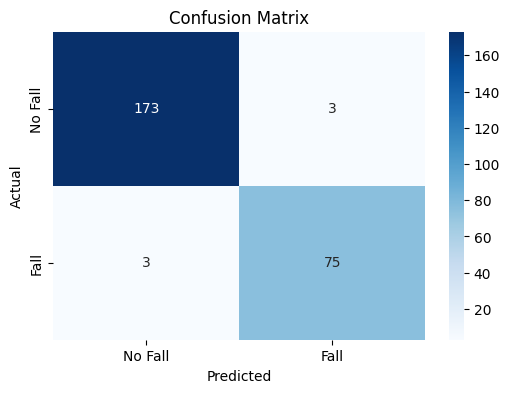

In [ ]:
ensemble_predict(
    models_with_features=[
        ("models/MF_XGB_Optuna.pkl", ["max", "min", "mean", "std", "median", "peak", "p2p", "energy", "rms", "crest", "shape", "impulse", "margin"]),  
        ("models/MF_XGB_RD40_Optuna.pkl", ["median", "max", "peak", "mean", "p2p"]),
        ("models/MF_XGB_RD41_Optuna.pkl", ["median", "max", "peak", "mean", "p2p"])    
    ],
    dataset_name="MPU_features_pca.csv",
    target_column="fall_binary"
)
